# Feature Practice - CWRU

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import hilbert
import z_dependancy as z_dep
plt.rc('font', size=20)

# 데이터 로드

## 회전 주파수 알아보기

In [2]:
F_shaft_rpm = 1797
F_shaft = F_shaft_rpm/60
print('Shaft Frequency is', F_shaft)

Shaft Frequency is 29.95


## 베어링 주파수 DB 만들기

In [3]:
F_BPFI = 5.4152
F_BPFO = 3.5848
F_FTF = 0.398
F_BSF = 4.7135

F_BPFI_w = F_BPFI*F_shaft
F_BPFO_w = F_BPFO*F_shaft
F_FTF_w = F_FTF*F_shaft
F_BSF_w = F_BSF*F_shaft

print('Outer Race Fault Frequency is', F_BPFO_w)

Outer Race Fault Frequency is 107.36476


## 신호 로드하고 그려보기

In [4]:
fs=12000

### 신호를 로드해 주세요. 
정상 데이터를 v_n, 결함 데이터를 v_f로 지정해 주세요

In [5]:
data = np.array(pd.read_csv('./data/data_normal.csv'))
v_n = data[:,1]

data = np.array(pd.read_csv('./data/data_fault.csv'))
v_f = data[:,1]

### 정상, 고장 신호를 한 그래프에 그려주세요

(-4.0, 4.0)

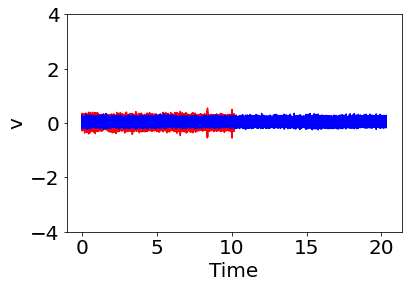

In [6]:
T_n = len(v_n)/fs               # 전체 샘플수 / 1초당 샘플수 = 총 시간
t_n=np.arange(1/fs, T_n, 1/fs)  # 1/fs초 부터 T초까지 1/fs초 간격
T_f = len(v_f)/fs
t_f = np.arange(1/fs, T_f, 1/fs)

plt.figure()
plt.plot(t_f,v_f,'r')
plt.plot(t_n,v_n,'b')
plt.xlabel('Time')
plt.ylabel('v')
plt.ylim([-4,4])

## 주파수 분석해보기

### 정상, 고장 신호에 대해 주파수 분석을 한 후 한 그래프에 그려주세요

(0.0, 0.06)

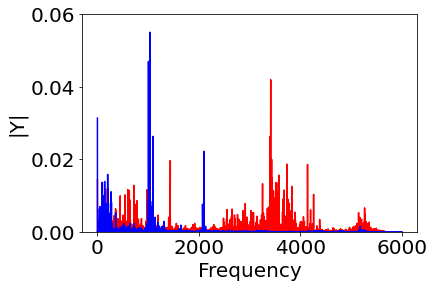

In [7]:
f_n, A_n = z_dep.z_fft_simple(v_n,fs)
f_f, A_f = z_dep.z_fft_simple(v_f,fs)

plt.figure()
plt.plot(f_f,A_f,'r')
plt.plot(f_n,A_n,'b')
plt.xlabel('Frequency')
plt.ylabel('|Y|')
plt.ylim([0,0.06])

# Feature 추출

In [24]:
band=np.matrix([[F_BPFO_w*0.9, F_BPFO_w*1.1],
                [2*F_BPFO_w*0.9, 2*F_BPFO_w*1.1],
                [3*F_BPFO_w*0.9, 3*F_BPFO_w*1.1],
                [400,900],
                [2000,4500],
                [4500,5999]
                ])

print(band)

[[  96.628284  118.101236]
 [ 193.256568  236.202472]
 [ 289.884852  354.303708]
 [ 400.        900.      ]
 [2000.       4500.      ]
 [4500.       5999.      ]]


## Raw Data로 Feature 추출해보기

In [25]:
feature_t_n, feature_t_name = z_dep.z_feature_time(v_n)
feature_t_f, feature_t_name = z_dep.z_feature_time(v_f)
feature_t_ratio = feature_t_f/feature_t_n

feature_f_n, feature_f_name = z_dep.z_feature_freq(v_n, fs, band)
feature_f_f, feature_f_name = z_dep.z_feature_freq(v_f, fs, band)
feature_f_ratio = feature_f_f/feature_f_n

### CF 및 고주파 Band Energy 유의차 발견
### -> 해당 변화의 원인은? 필터링 / 포락선 분석 필요!

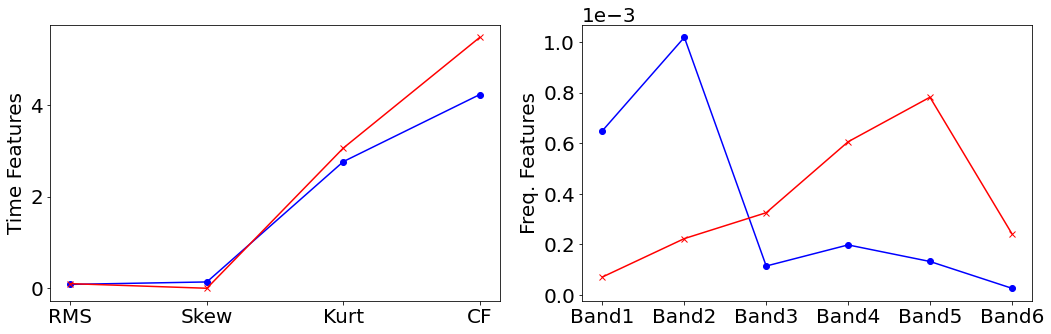

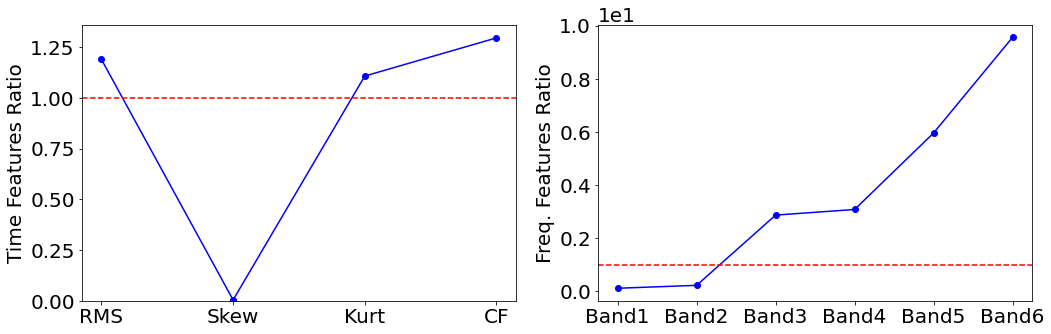

In [26]:
z_dep.z_draw_features(feature_t_n, feature_t_f, feature_t_name, 
                      feature_f_n, feature_f_f, feature_f_name)

## 필터링 데이터로 Feature 추출해보기

In [27]:
ftype='band'
Wn=np.array([2000,4500])
print(Wn)

[2000 4500]


### 정상, 고장 신호에 대해 필터링을 수행해 주세요.
정상신호에 대한 결과는 v_filter_n, 결함신호에 대한 결과는 v_filter_f 라는 변수로 지정해 주세요.

In [28]:
v_filter_n = z_dep.filtering(v_n, fs, Wn, ftype)
v_filter_n[0:100] = 0
v_filter_f = z_dep.filtering(v_f, fs, Wn, ftype)
v_filter_f[0:100] = 0

(-2.0, 2.0)

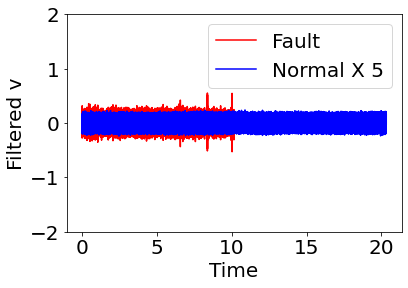

In [31]:
plt.figure()
plt.plot(t_f,v_filter_f,'r')
plt.plot(t_n,v_filter_n*5,'b')
plt.xlabel('Time')
plt.ylabel('Filtered v')
plt.legend(['Fault','Normal X 5'])
plt.ylim([-2,2])

In [32]:
feature_filter_t_n, feature_filter_t_name = z_dep.z_feature_time(v_filter_n)
feature_filter_t_f, feature_filter_t_name = z_dep.z_feature_time(v_filter_f)
feature_filter_t_ratio = feature_filter_t_f/feature_filter_t_n

feature_filter_f_n, feature_filter_f_name = z_dep.z_feature_freq(v_filter_n, fs, band)
feature_filter_f_f, feature_filter_f_name = z_dep.z_feature_freq(v_filter_f, fs, band)
feature_filter_f_ratio = feature_filter_f_f/feature_filter_f_n

### 좌측 (시간 도메인 Feature가 중요) -> 차이가 벌어짐!

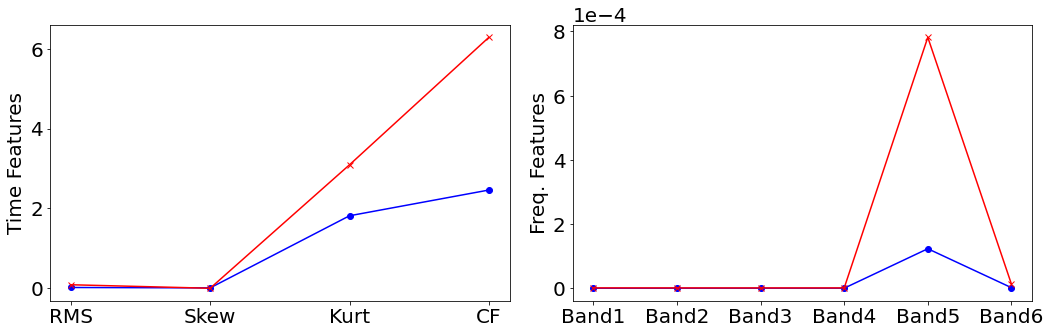

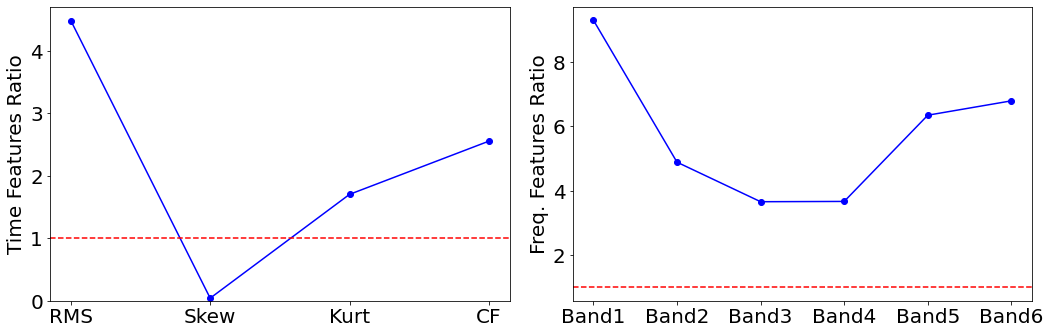

In [33]:
z_dep.z_draw_features(feature_filter_t_n, feature_filter_t_f, feature_filter_t_name,
                      feature_filter_f_n, feature_filter_f_f, feature_filter_f_name)

## 필터링 포락선 데이터로 Feature 추출해보기

### 정상, 고장 신호의 필터링 결과에 대해 포락선 분석을 수행해 주세요.
정상신호에 대한 결과는 v_filter_env_n, 결함신호에 대한 결과는 v_filter_env_f 라는 변수로 지정해 주세요.

In [34]:
v_filter_env_n = abs(hilbert(v_filter_n,axis=0));
v_filter_env_f = abs(hilbert(v_filter_f,axis=0));

In [35]:
feature_filter_env_t_n, feature_filter__envt_name = z_dep.z_feature_time(v_filter_env_n)
feature_filter_env_t_f, feature_filter_env_t_name = z_dep.z_feature_time(v_filter_env_f)
feature_filter_env_t_ratio = feature_filter_env_t_f/feature_filter_env_t_n

feature_filter_env_f_n, feature_filter_env_f_name = z_dep.z_feature_freq(v_filter_env_n, fs, band)
feature_filter_env_f_f, feature_filter_env_f_name = z_dep.z_feature_freq(v_filter_env_f, fs, band)
feature_filter_env_f_ratio = feature_filter_env_f_f/feature_filter_env_f_n

### 우측 (주파수 도메인 Feature 중 저주파 대역이 중요)

### 포락선 분석 결과 베어링 Outer Race 결함 확인!

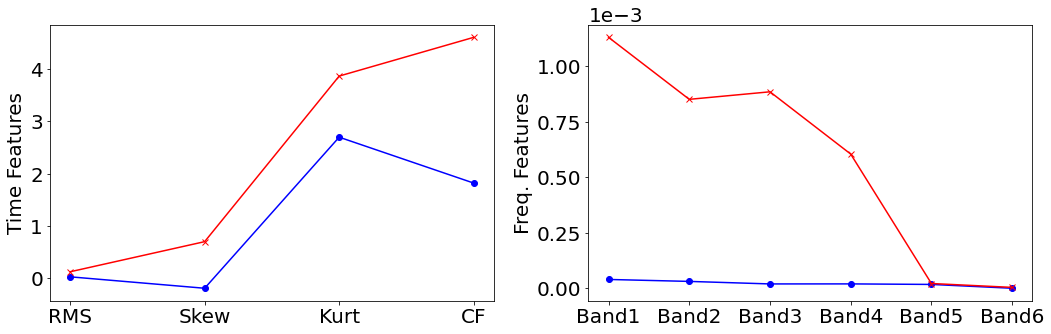

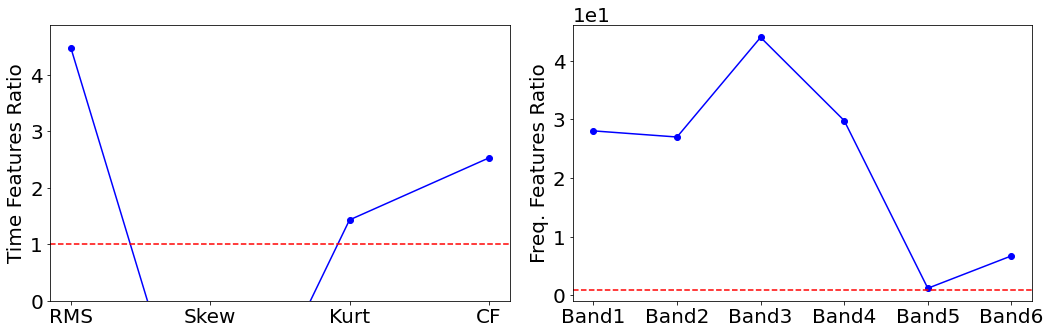

In [36]:
z_dep.z_draw_features(feature_filter_env_t_n, feature_filter_env_t_f, feature_filter_env_t_name,
                      feature_filter_env_f_n, feature_filter_env_f_f, feature_filter_env_f_name)